<a href="https://colab.research.google.com/github/InzOprog/ABB/blob/main/JAX_Tests/JAX_test1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
#math
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

#data
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

#utils
import matplotlib.pyplot as plt
import itertools as it

In [52]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(
        layer_widths[:-1], 
        layer_widths[1:], 
        keys
        ):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, 
                                               shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, 
                                               shape=(out_width,))
                       ]
        )

    return params

"""
test 1)
sprawdzenie poprawności generowana warstw o wielkości [784, 512, 256, 10]
gdzie 784 to warstwa wejścia (28*28[px]), 
10 to warstwa wyjścia gdzie każdy node odpowada innej cyfsze w granicy 0-9,
512 i 256 to warstwy ukryte

Oczekiwany kształt to a_x := [(n_x+1, n_x), (n_x+1,)], długość tablicy o jeden
mniejsza od długości tablicy warstw reprezentowanej jako %layer_widths.
"""
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [53]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    """
    JAX nie posiada implementacji Cross-entropy Loss
    
    Implementacja log-softmax
    log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))    logits
    log( exp(o1) / sum(...) )                                   logsumexp(logits)
    """
    return logits - logsumexp(logits)

# Testy

# Testy kształtów
dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape) #Wymagane 784 (MLP_params)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape) #Wynagane 10 (MLP_params)

# Test kształtów i poprawnośni funkcji dla wielu wejść (batch processing)
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [54]:
# Zmiana w 1D np.array.
# Własna zdefiniowana funkcja transformacji ze wslględu na użycie JAX a nie TenserFlow czy PyTorch
def numpy_and_flatten(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=numpy_and_flatten)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=numpy_and_flatten)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory (smal dataset 50-60k images)
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [55]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.23489156
0.092770584
0.06370979
0.050554466
0.04470199
0.02863811
0.04440702
0.033614565
0.026201248
0.02318023
Epoch 0, train acc = 0.916700005531311 test acc = 0.9199000000953674
0.02037966
0.029082492
0.024066329
0.027654782
0.025059426
0.025652489
0.03125443
0.032713253
0.019199202
0.016881783
Epoch 1, train acc = 0.9345166683197021 test acc = 0.936199963092804
0.024983672
0.023811528
0.030246407
0.017450018
0.014059285
0.013737607
0.027218629
0.026299948
0.025642836
0.019032069
Epoch 2, train acc = 0.947700023651123 test acc = 0.9453999996185303
0.016679479
0.0135741895
0.0136773465
0.0149416
0.01767776
0.01567529
0.015940113
0.018217891
0.018011862
0.012915038
Epoch 3, train acc = 0.9544166922569275 test acc = 0.9506999850273132
0.016069254
0.014223459
0.017625183
0.013568888
0.020354725
0.01197791
0.021036252
0.022936067
0.024598205
0.009850338
Epoch 4, train acc = 0.9596166610717773 test acc = 0.9557999968528748


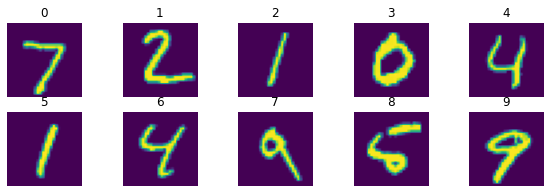

[0]	-	7 | [1]	-	2 | [2]	-	1 | [3]	-	0 | [4]	-	4 | [5]	-	1 | [6]	-	4 | [7]	-	9 | 
[8]	-	5 | [9]	-	9 | [10]	-	0 | [11]	-	6 | [12]	-	9 | [13]	-	0 | [14]	-	1 | [15]	-	5 | 
[16]	-	9 | [17]	-	7 | [18]	-	3 | [19]	-	4 | [20]	-	9 | [21]	-	6 | [22]	-	6 | [23]	-	5 | 
[24]	-	4 | [25]	-	0 | [26]	-	7 | [27]	-	4 | [28]	-	0 | [29]	-	1 | [30]	-	3 | [31]	-	1 | 
[32]	-	3 | [33]	-	4 | [34]	-	7 | [35]	-	2 | [36]	-	7 | [37]	-	1 | [38]	-	2 | [39]	-	1 | 
[40]	-	1 | [41]	-	7 | [42]	-	4 | [43]	-	2 | [44]	-	3 | [45]	-	5 | [46]	-	1 | [47]	-	2 | 
[48]	-	4 | [49]	-	4 | [50]	-	6 | [51]	-	3 | [52]	-	5 | [53]	-	5 | [54]	-	6 | [55]	-	0 | 
[56]	-	4 | [57]	-	1 | [58]	-	9 | [59]	-	5 | [60]	-	7 | [61]	-	8 | [62]	-	9 | [63]	-	3 | 
[64]	-	7 | [65]	-	4 | [66]	-	6 | [67]	-	4 | [68]	-	3 | [69]	-	0 | [70]	-	7 | [71]	-	0 | 
[72]	-	2 | [73]	-	9 | [74]	-	1 | [75]	-	7 | [76]	-	3 | [77]	-	2 | [78]	-	9 | [79]	-	7 | 
[80]	-	7 | [81]	-	6 | [82]	-	2 | [83]	-	7 | [84]	-	8 | [85]	-	4 | [86]	-	7 | [87]	-	3 | 
[88]	-	6 | [89]	-	1 | [90]	-	3 

In [56]:
tl_iter = iter(test_loader)

imgs, lbls = next(tl_iter)
imgs2, lbls2 = next(tl_iter)

fig, axs = plt.subplots(2, 5, figsize=(10, 3))
for id in range(5):
  axs[0][id].imshow(imgs[id].reshape(mnist_img_size))
  axs[0][id].axis('off')
  axs[0][id].set_title(f'{id}')

for id in range(5, 10):
  axs[1][id-5].imshow(imgs[id].reshape(mnist_img_size))
  axs[1][id-5].axis('off')
  axs[1][id-5].set_title(f'{id}')

plt.show()

out = ""
for id, lbl in enumerate(lbls):
  out += "[%s]\t-\t%s | " %(id, lbl)
  if((id+1)%8==0): out += '\n'
print(out)

(28, 28)
pred 6
gt 5


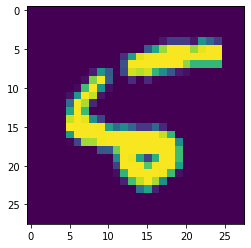

In [59]:
img_id = 8
imgs, lbls = next(iter(test_loader))
img = imgs[img_id].reshape(mnist_img_size)
gt_lbl = lbls[img_id]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

In [58]:
tl_iter = iter(test_loader)

imgs1, lbls1 = next(tl_iter)
imgs2, lbls2 = next(tl_iter)
imgs3, lbls3 = next(tl_iter)
imgs4, lbls4 = next(tl_iter)
imgs5, lbls5 = next(tl_iter)

all_imgs = [imgs1, imgs2, imgs3, imgs4, imgs5]
all_lbls = [lbls1, lbls2, lbls3, lbls4, lbls5]

sum = 0
bad = []
for id, (img, lbl) in enumerate(zip(it.chain(imgs1, imgs2, imgs3, imgs4, imgs5), it.chain(lbls1, lbls2, lbls3, lbls4, lbls5))):
  pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
  if pred == lbl:
    sum += 1
  else:
    bad.append([id, pred, lbl])
print(sum*100/(len(lbls1) + len(lbls2) + len(lbls3) + len(lbls4) + len(lbls5)))
for i, p, l in bad:
  print("%s\t|\t%s\t|\t%s"%(i, p, l))

95.0
8	|	6	|	5
124	|	4	|	7
149	|	4	|	2
151	|	8	|	9
233	|	7	|	8
241	|	8	|	9
245	|	5	|	3
247	|	2	|	4
259	|	0	|	6
300	|	6	|	4
318	|	3	|	2
320	|	1	|	9
321	|	7	|	2
340	|	3	|	5
352	|	0	|	5
386	|	5	|	6
389	|	4	|	9
412	|	3	|	5
445	|	0	|	6
448	|	8	|	9
449	|	5	|	3
479	|	8	|	9
495	|	2	|	8
543	|	3	|	8
551	|	1	|	7
565	|	9	|	4
578	|	2	|	3
582	|	2	|	8
591	|	3	|	8
610	|	2	|	4
619	|	8	|	1
627	|	4	|	9


Trafność przewidywań przez AI:
<table>
<tr><td>1</td><td>epoch</td><td>=</td><td>92[±1.0]%</td></tr>
<tr><td>10</td><td>epoch</td><td>=</td><td>98[±1.0]%</td></tr>
<tr><td>50</td><td>epoch</td><td>=</td><td>99[±1.0]%</td></tr>
</table>
Zauważone: Diminishing returns.